In [1]:
from data import load_data

clinical, _, genes, treatments, outcome = load_data()

clinical.head()

,cmmc,ecog_ps,percent_aneuploid,percent_plama_cells_bone_marrow,percent_plama_cells_peripherical_blood,creatinine,iss,absolute_neutrophil,platelet,wbc_x10_10_9_l,...,m_protein,first_line_transplant,cell_markers_cd117,cell_markers_cd13,cell_markers_cd138,cell_markers_cd38,race_asian,race_black_african_american,race_other,race_white
ID,,,,,,,,,,,,,,,,,,,,,
MMRF1021,NaN,1.0,0.0,4.9,0.0,88.400,1.0,2.40,216.0,5.2,...,3.05,1,0,1,0,0,0,0,0,1
MMRF1024,NaN,1.0,11.0,6.0,0.0,123.760,2.0,2.30,188.0,4.3,...,2.60,0,1,0,0,0,0,0,0,1
MMRF1029,NaN,1.0,0.0,8.4,0.0,106.080,1.0,2.60,219.0,4.0,...,1.80,0,1,0,0,0,0,0,0,1
MMRF1030,NaN,1.0,15.4,9.6,0.0,55.692,1.0,2.50,215.0,4.7,...,3.55,1,1,0,0,0,0,0,0,1
MMRF1031,NaN,NaN,18.3,10.1,0.0,81.328,1.0,10.29,385.0,12.4,...,1.52,0,1,0,0,0,0,0,0,1


In [71]:
treatments.columns = [c.replace('therapy_first_line_Non-therapy', 'therapy_first_line_Non-treatment') for c in treatments.columns]

treatments.head()

,therapy_first_line_Bor-Cyc-Dex,therapy_first_line_Bor-Dex,therapy_first_line_Bor-Len-Dex,therapy_first_line_Len-Dex,therapy_first_line_Non-treatment
ID,,,,,
MMRF1021,0,0,1,0,0
MMRF1024,0,0,0,0,1
MMRF1029,0,0,1,0,0
MMRF1030,0,0,1,0,0
MMRF1031,0,0,1,0,0


# THERAPY SENSITIVITY MODELLING

In [145]:
from pipeline import NMLA

from sklearn.model_selection import StratifiedKFold
from evaluation import optimize_threshold, classification_metrics
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix

from constants import N_FOLDS, RANDOM_STATE
from util import join_values

import lightgbm as lgb
import pickle as pkl
import pandas as pd
import numpy as np
import time
import os

# creating analyser object to compute and group 
# classification matrics grouped by training and validation
# dataset and by experiment id
# analyser = Analyser()

# Creating 10-fold CV splits stratified by treatment and outcome
kfold = StratifiedKFold(N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
split = kfold.split(np.zeros(outcome.shape[0]), join_values([treatments, outcome]))
    
# creating result structure
simulation = {c: [] for c in ['ACTUAL_TREATMENT']}

# creating
x, y = clinical.values[:, 1:], clinical.values[:, 0]


for experiment, (train_index, valid_index) in enumerate(split):
    
    initial_time = time.time()
    
    print('{}\n\n'.format(experiment))
    
    #######################################################################################################
    # Split train & valid
    #######################################################################################################
    
    y_train = outcome.iloc[train_index, 0]
    y_valid = outcome.iloc[valid_index, 0]

    clinical_train = clinical.iloc[train_index, :]
    clinical_valid = clinical.iloc[valid_index, :]

    treatments_train = treatments.iloc[train_index, :]
    treatments_valid = treatments.iloc[valid_index, :]
    
    genes_train = genes.iloc[train_index, :]
    genes_valid = genes.iloc[valid_index, :]

    #######################################################################################################
    # NMLA load
    #######################################################################################################

    with open('output/nmla/trained_model_{}.pkl'.format(experiment), 'rb') as file:
        nmla = pkl.load(file)
    
    #######################################################################################################
    # Treatment Simulation
    #######################################################################################################
    
    local_simulation = pd.DataFrame({'ID': clinical.index})
    
    actual_treatment = treatments_valid.idxmax(axis=1)
    actual_treatment = actual_treatment.str.replace('Non-therapy', 'Non-treatment').to_list()

    simulation['ACTUAL_TREATMENT'] += actual_treatment  
    
    for t1 in treatments.columns:
        
        if t1 not in simulation:
            simulation[t1] = []
        
        # t1 is the current treatment
        # this for just set 1 for current treatment
        # and 0 for remainder
        for t2 in treatments.columns:
            treatments_valid[t2] = float(t1 == t2)
        
        simulation[t1] += list(nmla.predict(clinical_valid, genes_valid, treatments_valid))
    
    del nmla

0


INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_000\graph\data_augmentation_adadelta_000
INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_000\graph\data_augmentation_adadelta_000
INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_000\graph\data_augmentation_adadelta_000
INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_000\graph\data_augmentation_adadelta_000
INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_000\graph\data_augmentation_adadelta_000
1


INFO:tensorflow:Restoring parameters from C:\Users\Venezian\git\multiple-myeloma\output\nmla\dae\data_augmentation_adadelta_001\graph\data_augmentation_adadelta_001
IN

# With Non-treatment

In [146]:
simulation = pd.DataFrame(simulation)
# simulation = simulation[simulation['ACTUAL_TREATMENT'] != 'therapy_first_line_Non-treatment']
simulation['SIMULATED_TREATMENT'] = simulation[treatments.columns].idxmax(axis=1)
simulation['SIMULATED_TREATMENT'] = simulation.apply(lambda x: x['ACTUAL_TREATMENT'] if x[x['ACTUAL_TREATMENT']] == x[treatments.columns].max() else x['SIMULATED_TREATMENT'], axis=1)
simulation.head()

,ACTUAL_TREATMENT,therapy_first_line_Bor-Cyc-Dex,therapy_first_line_Bor-Dex,therapy_first_line_Bor-Len-Dex,therapy_first_line_Len-Dex,therapy_first_line_Non-treatment,SIMULATED_TREATMENT
0,therapy_first_line_Bor-Len-Dex,0.058789,0.058789,0.067989,0.058789,0.167908,therapy_first_line_Non-treatment
1,therapy_first_line_Bor-Len-Dex,0.383536,0.383536,0.383536,0.383536,0.471019,therapy_first_line_Non-treatment
2,therapy_first_line_Bor-Len-Dex,0.299580,0.299580,0.299580,0.299580,0.422970,therapy_first_line_Non-treatment
3,therapy_first_line_Bor-Cyc-Dex,0.071205,0.071205,0.080405,0.071205,0.205416,therapy_first_line_Non-treatment
4,therapy_first_line_Bor-Len-Dex,0.471740,0.471740,0.471740,0.471740,0.562483,therapy_first_line_Non-treatment


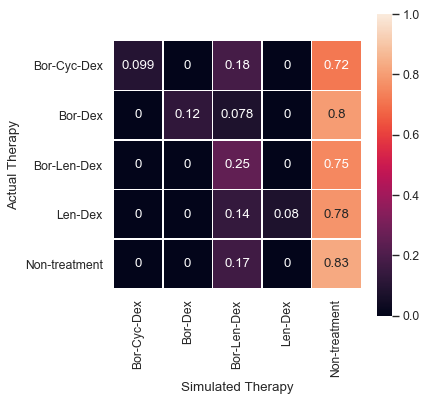

In [147]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

def change_proportion(x):
    vvv = x['ACTUAL_TREATMENT'].tolist()

    return x.shape[0] / (simulation['ACTUAL_TREATMENT'] == np.unique(vvv)[0]).sum()

h = pd.DataFrame(simulation[['SIMULATED_TREATMENT', 'ACTUAL_TREATMENT']].groupby(
    ['ACTUAL_TREATMENT', 'SIMULATED_TREATMENT']).apply(change_proportion).unstack())

# h['non-therapy'] = 0

h.columns = [c.replace('therapy_first_line_', '') for c in h.columns]
h.index = [c.replace('therapy_first_line_', '') for c in h.index]
h = h.sort_index()[sorted(h.columns)].fillna(0)

fig, ax = plt.subplots(1, 1, figsize = (5, 5), dpi=80)

sns.heatmap(h, vmin=0.0, vmax=1, square=True, linewidths=.5, annot=True)

ax.set_ylabel('Actual Therapy')    
ax.set_xlabel('Simulated Therapy')

plt.show()

In [156]:
(simulation['ACTUAL_TREATMENT'] != simulation['SIMULATED_TREATMENT']).sum() / simulation.shape[0]

0.6160220994475138

# Without Non-treatment

In [151]:
simulation_ = pd.DataFrame(simulation)
simulation_ = simulation_[simulation_['ACTUAL_TREATMENT'] != 'therapy_first_line_Non-treatment']
simulation_['SIMULATED_TREATMENT'] = simulation_[treatments.columns[:-1]].idxmax(axis=1)
simulation_['SIMULATED_TREATMENT'] = simulation_.apply(lambda x: x['ACTUAL_TREATMENT'] if x[x['ACTUAL_TREATMENT']] == x[treatments.columns[:-1]].max() else x['SIMULATED_TREATMENT'], axis=1)
simulation_.head()

,ACTUAL_TREATMENT,therapy_first_line_Bor-Cyc-Dex,therapy_first_line_Bor-Dex,therapy_first_line_Bor-Len-Dex,therapy_first_line_Len-Dex,therapy_first_line_Non-treatment,SIMULATED_TREATMENT
0,therapy_first_line_Bor-Len-Dex,0.058789,0.058789,0.067989,0.058789,0.167908,therapy_first_line_Bor-Len-Dex
1,therapy_first_line_Bor-Len-Dex,0.383536,0.383536,0.383536,0.383536,0.471019,therapy_first_line_Bor-Len-Dex
2,therapy_first_line_Bor-Len-Dex,0.299580,0.299580,0.299580,0.299580,0.422970,therapy_first_line_Bor-Len-Dex
3,therapy_first_line_Bor-Cyc-Dex,0.071205,0.071205,0.080405,0.071205,0.205416,therapy_first_line_Bor-Len-Dex
4,therapy_first_line_Bor-Len-Dex,0.471740,0.471740,0.471740,0.471740,0.562483,therapy_first_line_Bor-Len-Dex


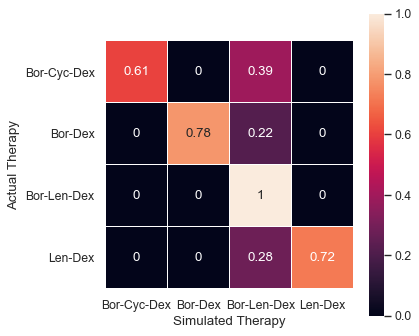

In [152]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

def change_proportion(x):
    vvv = x['ACTUAL_TREATMENT'].tolist()

    return x.shape[0] / (simulation_['ACTUAL_TREATMENT'] == np.unique(vvv)[0]).sum()

h = pd.DataFrame(simulation_[['SIMULATED_TREATMENT', 'ACTUAL_TREATMENT']].groupby(
    ['ACTUAL_TREATMENT', 'SIMULATED_TREATMENT']).apply(change_proportion).unstack())

# h['non-therapy'] = 0

h.columns = [c.replace('therapy_first_line_', '') for c in h.columns]
h.index = [c.replace('therapy_first_line_', '') for c in h.index]
h = h.sort_index()[sorted(h.columns)].fillna(0)

fig, ax = plt.subplots(1, 1, figsize = (5, 5), dpi=80)

sns.heatmap(h, vmin=0.0, vmax=1, square=True, linewidths=.5, annot=True)

ax.set_ylabel('Actual Therapy')    
ax.set_xlabel('Simulated Therapy')

plt.show()

In [155]:
(simulation_['ACTUAL_TREATMENT'] != simulation_['SIMULATED_TREATMENT']).sum() / simulation_.shape[0]

0.17073170731707318

In [168]:
simulation_.columns = [c.replace('therapy_first_line_', '').lower() for c in simulation_.columns]
simulation_['actual_treatment'] = simulation_['actual_treatment'].str.replace('therapy_first_line_', '')
simulation_['simulated_treatment'] = simulation_['simulated_treatment'].str.replace('therapy_first_line_', '')

if 'Non-treatment' in simulation_:
    del simulation_['Non-treatment']
    
simulation_.to_csv('output/simulation/simulation.csv', sep=',', index=False)

simulation_.head()

,actual_treatment,bor-cyc-dex,bor-dex,bor-len-dex,len-dex,simulated_treatment
0,Bor-Len-Dex,0.058789,0.058789,0.067989,0.058789,Bor-Len-Dex
1,Bor-Len-Dex,0.383536,0.383536,0.383536,0.383536,Bor-Len-Dex
2,Bor-Len-Dex,0.299580,0.299580,0.299580,0.299580,Bor-Len-Dex
3,Bor-Cyc-Dex,0.071205,0.071205,0.080405,0.071205,Bor-Len-Dex
4,Bor-Len-Dex,0.471740,0.471740,0.471740,0.471740,Bor-Len-Dex
